## 01 - Carregar as bases

In [ ]:
import pandas as pd
df = pd.read_excel('base_final.xlsx', usecols='D: E')
df = df[df["efeito"]=="roubo"]

df.head(5)

,dsc_sinistro,efeito
26749,VEÍCULO SEGURADO SEGUIA VIA CITADA COM CONDUTO...,roubo
26750,condutor estava na via momento que ocorreu um ...,roubo
26751,ELE ESTAVA ABRINDO O ESTABELECIMENTO COMERCIAL...,roubo
26752,Veiculo segurado parado no local citado ao ret...,roubo
26753,Segurado trafegava na via Olavo Bilac e perceb...,roubo


## 02 - Análise Exploratória

In [ ]:
df.shape

(3363, 2)

In [ ]:
df['word_count'] = df['dsc_sinistro'].apply(lambda x: len(str(x).split()))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')
sns.set_palette('dark')
sns.set_context('talk')

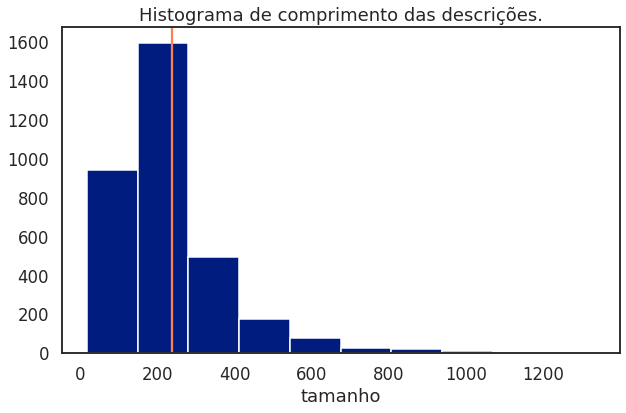

In [ ]:
avg_len = sum(df["dsc_sinistro"].str.len() ) / float(len(df["dsc_sinistro"].str.len()))

plt.figure(figsize=(10,6))
plt.hist(df["dsc_sinistro"].str.len() )
plt.axvline(avg_len, color='coral')
plt.title('Histograma de comprimento das descrições.')
plt.xlabel('tamanho')
plt.show()

## 03 - Pré Processamento

In [ ]:
import re,string

import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize.toktok import ToktokTokenizer
from bs4 import BeautifulSoup
import numpy as np

In [ ]:
tokenizer = ToktokTokenizer()
nltk.download('stopwords')
stopword_list = nltk.corpus.stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
!pip install pyLDAvis==2.1.2

     |████████████████████████████████| 1.6 MB 4.0 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97738 sha256=4fee2dfda6d588fab71cb43ea4fa47339078e062d3b823b7b93c11b95f8e0e3e
  Stored in directory: /root/.cache/pip/wheels/3b/fb/41/e32e5312da9f440d34c4eff0d2207b46dc9332a7b931ef1e89
Successfully built pyLDAvis


In [ ]:
'''Remove stopwords'''
def remove_stopwords(text):
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
  filtered_text = ' '.join(filtered_tokens)
  return filtered_text

'''Remove acentos'''
def remove_accent(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

'''Remove caracteres especiais'''
def remove_special_characters(text, remove_digits=False):
  special_char_pattern = re.compile(r'([{.(-)!}])')
  text = special_char_pattern.sub(" \\1 ", text)
  pattern = r'[^a-zA-z\s]'
  text = re.sub(pattern, '', text)
  return text

In [ ]:
#Funções para limpar texto: chama todas as funções declaradas acima e faz mais alguns pré processamentos
def clean(corpus):

  normalized_corpus = []
  for doc in corpus:
    # remove acentuação
    doc = remove_accent(doc)

    # coloca tudo em caixa baixa
    doc = doc.lower()

    # remove caracteres especiais 
    doc = remove_special_characters(doc)

    # remove stopwords
    doc = remove_stopwords(doc)

    # insere na lista o texto após limpeza
    normalized_corpus.append(doc)

  return normalized_corpus # retorna corpus pré processado

In [ ]:
normalized_corpus = clean(df.dsc_sinistro.to_list())

In [ ]:
df['dsc_sinistro_pos'] = normalized_corpus

In [ ]:
!pip install spacy
!python -m spacy download pt
import spacy
nlp = spacy.load('pt')

     |████████████████████████████████| 21.2 MB 1.3 MB/s 
  Created wheel for pt-core-news-sm: filename=pt_core_news_sm-2.2.5-py3-none-any.whl size=21186282 sha256=c0255fd1f015333ee19d7450ee690b2d90adf73f32776f22cf5012c3c793693e
  Stored in directory: /tmp/pip-ephem-wheel-cache-7a5ggaa_/wheels/c3/f9/0c/5c014a36941a00f5df5fc0756cb961d7c457a978e697a6ce3b
Successfully built pt-core-news-sm
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


In [ ]:
def lemmatize(text):
  text = nlp(text)
  text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
  return text

  #Definir função da lemmatização
def clean(corpus):

  normalized_corpus_lemma = []
  for doc in corpus:

    # lemmatização
    doc = lemmatize(doc)

    # insere na lista o texto após limpeza
    normalized_corpus_lemma.append(doc)

  return normalized_corpus_lemma # retorna corpus pré processado

#executar a lemetização
normalized_corpus_lemma = clean(df.dsc_sinistro_pos.to_list())  

In [ ]:
df['dsc_sinistro_lemma'] = normalized_corpus_lemma

In [ ]:
df.head()

,dsc_sinistro,efeito,word_count,dsc_sinistro_pos,dsc_sinistro_lemma
26749,VEÍCULO SEGURADO SEGUIA VIA CITADA COM CONDUTO...,roubo,62,veiculo segurado seguia via citada condutor aj...,veicular segurar seguir ver citar condutor aju...
26750,condutor estava na via momento que ocorreu um ...,roubo,18,condutor via momento ocorreu arrastao proximo ...,condutor ver momento ocorrer arrastao proximo ...
26751,ELE ESTAVA ABRINDO O ESTABELECIMENTO COMERCIAL...,roubo,26,abrindo estabelecimento comercial apareceu dua...,abrir estabelecimento comercial aparecer dois ...
26752,Veiculo segurado parado no local citado ao ret...,roubo,14,veiculo segurado parado local citado retornar ...,veicular segurar parar local citar retornar lo...
26753,Segurado trafegava na via Olavo Bilac e perceb...,roubo,37,segurado trafegava via olavo bilac percebeu du...,segurar trafegar ver olavo bilac perceber dois...


## 04 - Segmentação por Tópicos

In [ ]:
from gensim.models import ldamodel
from gensim.corpora.dictionary import Dictionary

In [ ]:
texts = []
for line in df.dsc_sinistro_lemma:
    lowered = line.lower()
    words = re.findall(r'\w+', lowered, flags = re.UNICODE)
    texts.append(words)
    
dictionary = Dictionary(texts)

dictionary.filter_extremes(no_below=2, no_above=0.90)

corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
num_topics = 4
chunksize = 2000
passes = 50
iterations = 200
eval_every = None

model = ldamodel.LdaModel( corpus=corpus, id2word=dictionary, chunksize=chunksize, alpha='auto', 
                          eta='auto', iterations=iterations, num_topics=num_topics, passes=passes, 
                          eval_every=eval_every, random_state=123)

In [ ]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(model, corpus, dictionary)
vis

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.146852 -0.147936       1        1  39.771716
3     -0.203461 -0.116105       2        1  26.821179
1     -0.106082  0.166889       3        1  19.751647
2      0.162691  0.097152       4        1  13.655458, topic_info=           Term         Freq        Total Category  logprob  loglift
112  estacionar  1580.000000  1580.000000  Default  30.0000  30.0000
49     retornar   956.000000   956.000000  Default  29.0000  29.0000
47        local  1736.000000  1736.000000  Default  28.0000  28.0000
2         armar  1441.000000  1441.000000  Default  27.0000  27.0000
58          nao  1455.000000  1455.000000  Default  26.0000  26.0000
..          ...          ...          ...      ...      ...      ...
58          nao    79.584670  1455.344811   Topic4  -4.8298  -0.9151
67       chegar    60.461771   312.769995   Topic4  -5.1047   0.3476
93   individuos    66.341455   580.866048   Topic4  -5.0118  -0.1787
142       homem    57.269865   220.386053   Topic4  -5.1589   0.6434
90      abordar    62.432992  1013.099280   Topic4  -5.0726  -0.7956

[327 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
90        1  0.936730  abordar
90        2  0.000987  abordar
90        3  0.000987  abordar
90        4  0.061198  abordar
35        1  0.218026    abrir
...     ...       ...      ...
2136      4  0.911927      vlc
89        1  0.003598   voltar
89        2  0.764622   voltar
89        3  0.205099   voltar
89        4  0.026087   voltar

[570 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

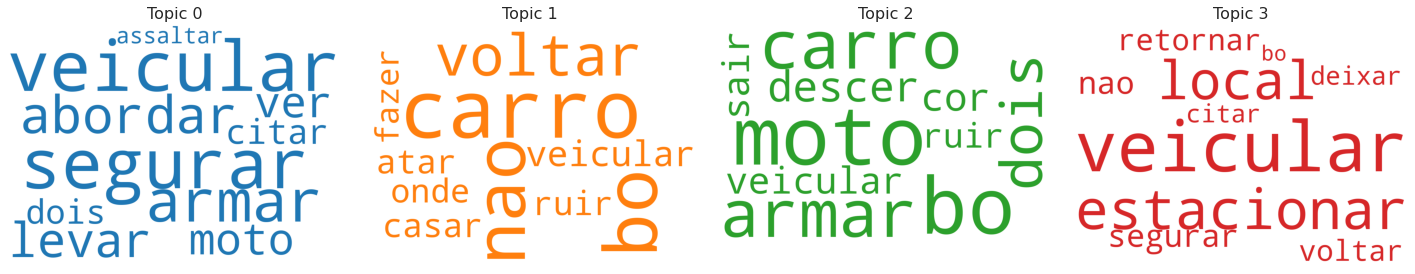

In [ ]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=1250,
                  height=900,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=0.6)
topics = model.show_topics(formatted=False)

fig, axes = plt.subplots(1, 4, figsize=(20,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [ ]:
all_topics = model.get_document_topics(corpus, minimum_probability=0)
all_topics[0]

[(0, 0.6762549), (1, 0.0022271683), (2, 0.08783739), (3, 0.23368056)]

In [ ]:
import gensim

all_topics_csr = gensim.matutils.corpus2csc(all_topics)
all_topics_numpy = all_topics_csr.T.toarray()

In [ ]:
Topic_0 = all_topics_numpy[:,0]
Topic_1 = all_topics_numpy[:,1]
Topic_2 = all_topics_numpy[:,2]
Topic_3 = all_topics_numpy[:,3]

In [ ]:
df['Topic_0'] = Topic_0
df['Topic_1'] = Topic_1
df['Topic_2'] = Topic_2
df['Topic_3'] = Topic_3

In [ ]:
conditions = [
    (df['Topic_0'] > df['Topic_1']) & (df['Topic_0'] > df['Topic_2']) & (df['Topic_0'] > df['Topic_3']),
    (df['Topic_1'] > df['Topic_2']) & (df['Topic_1'] > df['Topic_3']),
    (df['Topic_2'] > df['Topic_3']),
    (df['Topic_3'] > 0)
    ]

values = ['roubo', 'furto', 'roubo', 'furto']

df['Topic'] = np.select(conditions, values)

## 05 - Treinamento do Modelo

In [ ]:
from sklearn import metrics

def train_predict_model(classifier,
                       train_features, train_labels,
                       test_features , test_labels):
    classifier.fit(train_features, train_labels)
    predictions = classifier.predict(test_features)
    return predictions

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)

    cm_frame = pd.DataFrame(cm, index=classes, columns=classes,)
    cm_frame.index.name = 'Actual'
    cm_frame.columns.name = 'Predicted'

    print(cm_frame)

def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)

def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)
    
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))


Text(0.5, 1.0, 'Distribuição de Eventos por Tópico')

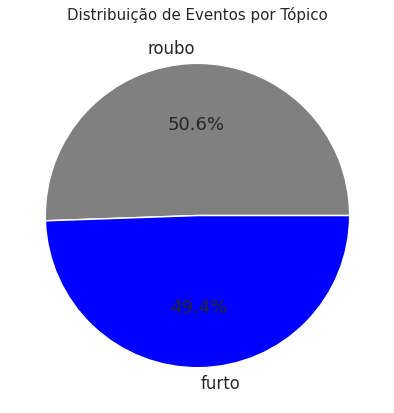

In [ ]:
df.Topic.dropna(inplace = True)
labels = df.Topic.value_counts().index
colors = ['grey','blue']
sizes = df.Topic.value_counts().values

plt.figure(figsize = (7,7))
plt.pie(sizes,labels=labels, colors=colors, autopct='%1.1f%%')
plt.title('Distribuição de Eventos por Tópico',fontsize = 15)

In [ ]:
from sklearn.model_selection import train_test_split

X = df['dsc_sinistro'].values
y = df['Topic'].values

train_features, test_features, class_train, class_test = train_test_split(X, y, test_size=0.20, random_state=123)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=10000)
cv_train_features = cv.fit_transform(train_features.ravel())
cv_test_features = cv.transform(test_features.ravel())

print('Shape das features de treino:', cv_train_features.shape, ' Shape das features de teste:', cv_test_features.shape)

Shape das features de treino: (2690, 7829)  Shape das features de teste: (673, 7829)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np

rfc = RandomForestClassifier(n_estimators=50, random_state=123)

rfc_tfidf_predictions = train_predict_model(classifier=rfc, 
                                                train_features=cv_train_features, train_labels=class_train,
                                                test_features=cv_test_features, test_labels=class_test)

display_model_performance_metrics(true_labels=class_test, predicted_labels=rfc_tfidf_predictions,classes=['furto', 'roubo'])

Model Performance metrics:
------------------------------
Accuracy: 0.9688
Precision: 0.9691
Recall: 0.9688
F1 Score: 0.9688

Model Classification report:
------------------------------
              precision    recall  f1-score   support

       furto       0.98      0.96      0.97       335
       roubo       0.96      0.98      0.97       338

    accuracy                           0.97       673
   macro avg       0.97      0.97      0.97       673
weighted avg       0.97      0.97      0.97       673


Prediction Confusion Matrix:
------------------------------
Predicted  furto  roubo
Actual                 
furto        320     15
roubo          6    332
